In [1]:
!pip install tsai optuna  optuna-integration -q
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [2]:
from pandas import read_pickle
import numpy as np
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *
from optuna import create_study
from optuna.pruners import HyperbandPruner
from optuna.importance import get_param_importances
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import FastAIPruningCallback
from random import seed
from gc import collect

* To get consistent results

In [3]:
torch.manual_seed(37)  # tsai is built on it so this should work..... I think?
seed(37)
np.random.seed(37)

In [4]:
df = read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [5]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])

In [6]:
# changed split method to split by bearing
raw_X, raw_y = ArrayGenerator.generate_dataset_array(
    dataset_category=2, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'BearingFault, BearingWear, BearingLubrication', 'Channels taken': 'According to label', 'Labels array': 'Binary'}


In [7]:
def ts_without_NaN(ts):
    new_ts = []
    for value in ts:
        if not np.isnan(value):
            new_ts.append(value)
    return new_ts

In [8]:
# Padding function
def pad(array_3d):
    max_length = max(len(sub_arr) for arr in array_3d for sub_arr in arr)
    padded_array_3d = [
        [
            np.pad(sub_arr, (0, max_length - len(sub_arr)), mode="constant")
            for sub_arr in arr
        ]
        for arr in array_3d
    ]
    return np.array(padded_array_3d)

In [9]:
# Purging NaN values from our data to get its FFT
x_nonan = []
for bearing in raw_X:
    x_nonan.append(bearing[:, ~np.any(np.isnan(bearing), axis=0)])

* for training on raw timeseries without windowing

In [10]:
x_nonan_padded = pad(x_nonan)

In [11]:
#  applying earlystopping to get the best results and to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
    SaveModelCallback(monitor="f1_score", comp=np.greater),
]

In [12]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]

In [13]:
report_splits = get_splits(raw_y, valid_size=0.2, shuffle=True, show_plot=False)
X_train1, y_train1 = raw_X[report_splits[0]], raw_y[report_splits[0]]
X_test1, y_test1 = raw_X[report_splits[1]], raw_y[report_splits[1]]

valid == train


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.784791,1.406730,0.457143,0.400000,0.533333,0.457143,0.466667,00:00
1,0.788587,9.677727,0.428571,0.428571,1.000000,0.600000,0.500000,00:00
2,0.728411,1.201726,0.685714,0.625000,0.666667,0.645161,0.683333,00:00
3,0.683122,0.881998,0.628571,0.600000,0.400000,0.480000,0.600000,00:00
4,0.666977,1.979067,0.457143,0.441176,1.000000,0.612245,0.525000,00:00
5,0.650198,0.539268,0.771429,0.733333,0.733333,0.733333,0.766667,00:00
6,0.636243,1.331449,0.428571,0.428571,1.000000,0.600000,0.500000,00:00
7,0.617753,0.478227,0.742857,0.650000,0.866667,0.742857,0.758333,00:00
8,0.601137,0.808362,0.485714,0.454545,1.000000,0.625000,0.550000,00:00
9,0.587478,0.552190,0.714286,0.600000,1.000000,0.750000,0.750000,00:00


Better model found at epoch 0 with f1_score value: 0.4571428571428572.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
14,0.533248,0.502045,0.8,0.681818,1.0,0.810811,0.825


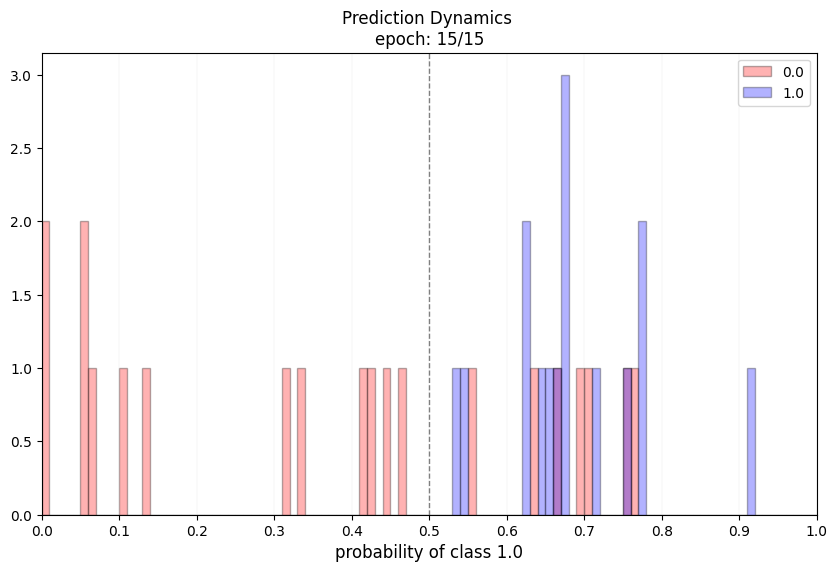

Better model found at epoch 1 with f1_score value: 0.6.
Better model found at epoch 2 with f1_score value: 0.6451612903225806.
Better model found at epoch 5 with f1_score value: 0.7333333333333333.
Better model found at epoch 7 with f1_score value: 0.7428571428571429.
Better model found at epoch 9 with f1_score value: 0.7499999999999999.
Better model found at epoch 11 with f1_score value: 0.7894736842105263.
Better model found at epoch 14 with f1_score value: 0.8108108108108109.


In [22]:
bs = 17
apply_sliding_window = 1  # suggest whether to apply sliding window or not
lr = 0.04277627637533716  # suggest learning rate
if apply_sliding_window:
    overlap_pct = 0.034366453220712294  # suggest overlap pct
    with_fft = 0  # suggest whether to apply FFT or not

    if overlap_pct > 0.5:  # to avoid an error in ArrayGenerator

        window_size1 = trial.suggest_categorical(
            "window_size1", [2048, 4096]
        )  # suggest window size # to avoid CategoricalDistribution does not support dynamic value space error
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=window_size1,
            with_fft=with_fft,
            overlap_pct=overlap_pct,
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1, y_test1, window_size=window_size1, with_fft=with_fft, overlap_pct=0
        )

    elif overlap_pct > 0.25:
        window_size2 = trial.suggest_categorical(
            "window_size2", [2048, 4096, 8192]
        )  # suggest window size
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=window_size2,
            with_fft=with_fft,
            overlap_pct=overlap_pct,
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1, y_test1, window_size=window_size2, with_fft=with_fft, overlap_pct=0
        )
    else:
        window_size3 = 16384  # suggest window size
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=window_size3,
            with_fft=with_fft,
            overlap_pct=overlap_pct,
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1, y_test1, window_size=window_size3, with_fft=with_fft, overlap_pct=0
        )
    train_balance_splits = get_splits(
        y_train,
        valid_size=0,
        balance=True,
        strategy="oversample",
        shuffle=True,
        show_plot=False,
    )
    X_train, y_train = (
        X_train[train_balance_splits[0]],
        y_train[train_balance_splits[0]],
    )
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    dls = get_ts_dls(
        X,
        y,
        splits=splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[bs, 256],
    )

else:

    dls = get_ts_dls(
        x_nonan_padded,
        raw_y,
        splits=report_splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[bs, 256],
    )
model = xresnet1d18(dls.vars, dls.c)

learn = Learner(
    dls,
    model,
    lr=lr,
    metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
)
#  applying earlystopping to get the best results and to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
    SaveModelCallback(monitor="f1_score", comp=np.greater),
]
learn.fit_one_cycle(15, cbs=callbacks);

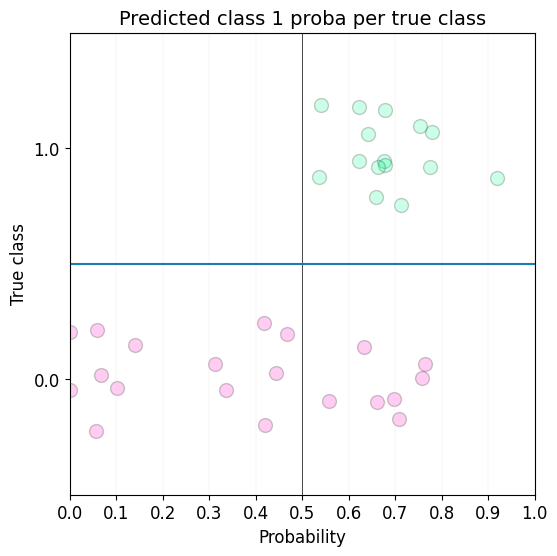

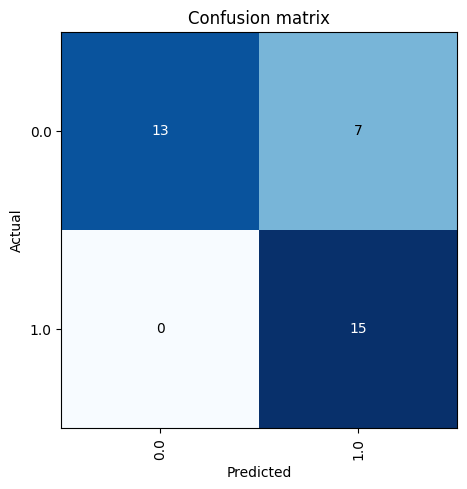

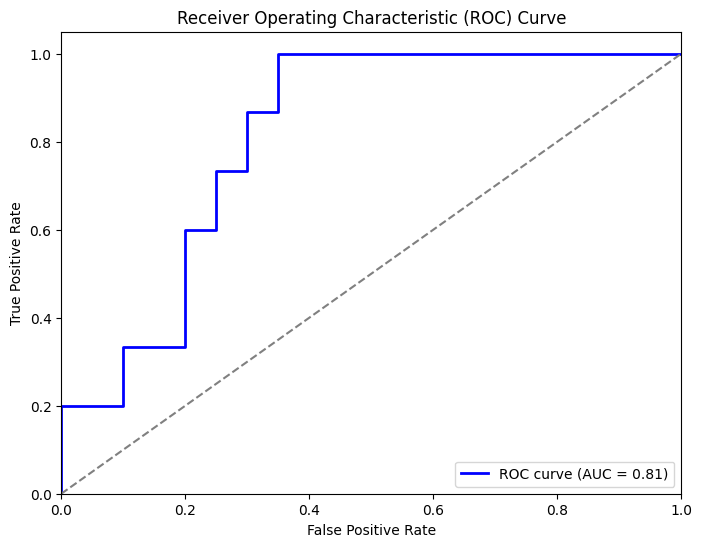

In [23]:
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()